## Autocorrelation Function

<Figure size 1000x600 with 0 Axes>

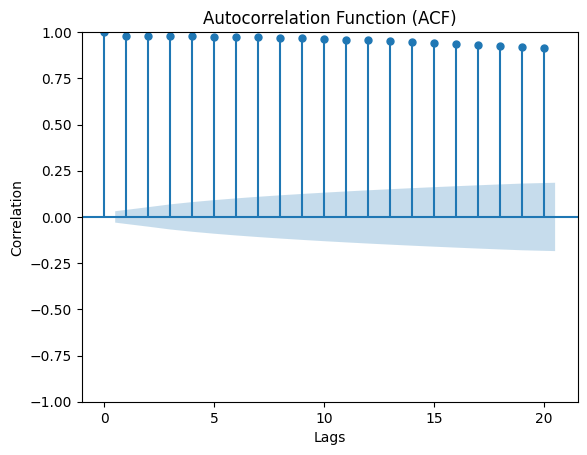

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

dataset = pd.read_csv('/content/simulated_data_feb17.csv')
data = dataset['Latitude_SV']

# Plot the ACF
plt.figure(figsize=(10, 6))
plot_acf(data, lags=20, alpha=0.05)  # lags=20 means we are considering 20 lags, alpha=0.05 for 95% confidence interval
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.show()

Non-stationary series often exhibit trends, seasonality, or other patterns that cause the autocorrelation to remain high across many lags. If the time series has a strong trend (e.g., consistently increasing or decreasing), the autocorrelation will remain high across all lags because the trend dominates the series. If the time series has strong seasonality, the autocorrelation will remain high at regular intervals (e.g., every 12 lags for monthly data). However, if the seasonality is very strong, it can also cause high autocorrelation across all lags.

## RMSE for SV and Satellite

In [ ]:
from sklearn.metrics import root_mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
dataset = pd.read_csv('/content/simulated_data_feb17.csv')

In [ ]:
# longitude data
sv_long = dataset['Longitude_SV']
sat_long = dataset['Longitude_Satellite']

root_mean_squared_error(sv_long, sat_long)

0.0004986272625360801

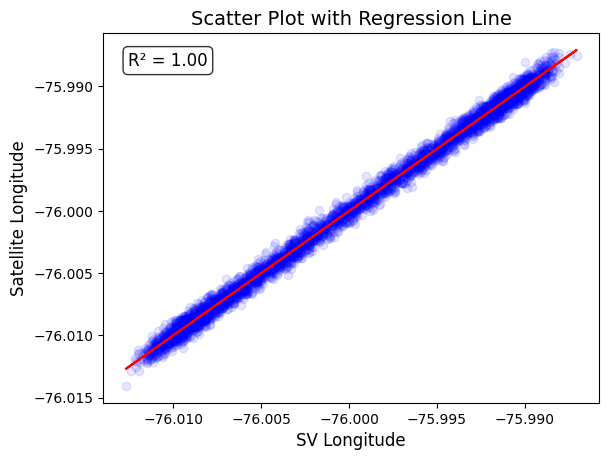

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(sv_long, sat_long)
regression_line = slope * sv_long + intercept
plt.scatter(sv_long, sat_long, color='blue', label='Data points', alpha=0.1)
plt.xlabel('SV Longitude', fontsize=12)
plt.ylabel('Satellite Longitude', fontsize=12)
plt.title('Scatter Plot with Regression Line', fontsize=14)
plt.text(0.05, 0.95, f'R² = {r_value**2:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.plot(sv_long, regression_line, color='red', label=f'Regression line: y = {slope:.2f}x + {intercept:.2f}')
plt.show()

In [ ]:
# latitude data
sv_lat = dataset["Latitude_SV"]
sat_lat = dataset['Latitude_Satellite']

root_mean_squared_error(sv_lat, sat_lat)

0.0004897658687810379

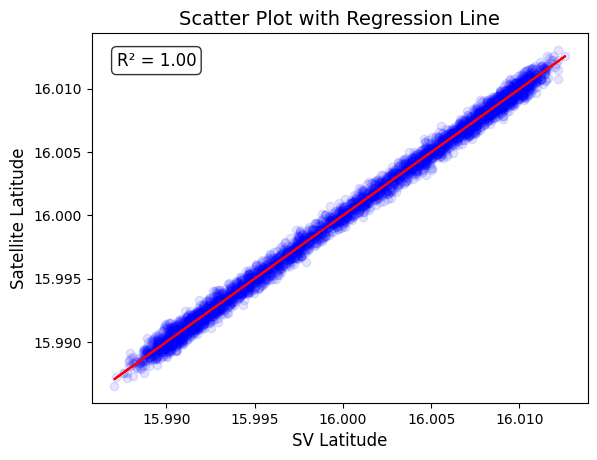

In [ ]:
slope, intercept, r_value, p_value, std_err = stats.linregress(sv_lat, sat_lat)
regression_line = slope * sv_lat + intercept
plt.scatter(sv_lat, sat_lat, color='blue', label='Data points', alpha=0.1)
plt.xlabel('SV Latitude', fontsize=12)
plt.ylabel('Satellite Latitude', fontsize=12)
plt.title('Scatter Plot with Regression Line', fontsize=14)
plt.text(0.05, 0.95, f'R² = {r_value**2:.2f}', transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.plot(sv_lat, regression_line, color='red', label=f'Regression line: y = {slope:.2f}x + {intercept:.2f}')
plt.show()

## LSTM

In [ ]:
# import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()

  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg

In [ ]:
dataset = pd.read_csv('/content/simulated_data_feb17.csv')
dataset = dataset.drop(columns=['timestamp'])
values = dataset.to_numpy()
encoder = LabelEncoder()
values[:,18] = encoder.fit_transform(values[:,18])
reframed = series_to_supervised(values,1,1)

values = reframed.values
# split October 1-12 for training and October 13-15 for testing
split_time = 3456
train = values[:split_time, :].astype('float32')
test = values[split_time:, :].astype('float32')
train_X, train_y = train[:, :-2], train[:, -2:-1]
test_X, test_y = test[:, :-2], test[:, -2:-1]

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming train_X, test_X, train_y, and test_y are already defined

# LSTM model
train_X = tf.expand_dims(train_X, axis=-1)
test_X = tf.expand_dims(test_X, axis=-1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=4, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(train_X.shape[1], train_X.shape[2])),
  tf.keras.layers.LSTM(4, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Set the training parameters
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mean_squared_error"])

# Fit the model
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), verbose=1, shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_X)

# Flatten the predictions and test_y if they have additional dimensions
predictions = [sublist[0] for sublist in predictions]
test_y = test_y.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print(f"RMSE: {rmse}")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 65.3281 - mean_squared_error: 13617.6562 - val_loss: 7.0014 - val_mean_squared_error: 167.0018
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.7057 - mean_squared_error: 90.4844 - val_loss: 3.5770 - val_mean_squared_error: 27.1799
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 8.1750 - mean_squared_error: 114.4871 - val_loss: 16.7431 - val_mean_squared_error: 319.4753
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 10.6182 - mean_squared_error: 154.6636 - val_loss: 6.4454 - val_mean_squared_error: 57.4783
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.1185 - mean_squared_error: 85.1672 - val_loss: 7.8242 - val_mean_squared_error: 76.2624
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 11.8249 - mean_squared_error: 216.6194 - val_loss: 8.7706 - val_mean_squared_error: 92.5872
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 10.8879 - mean_squared_error: 14

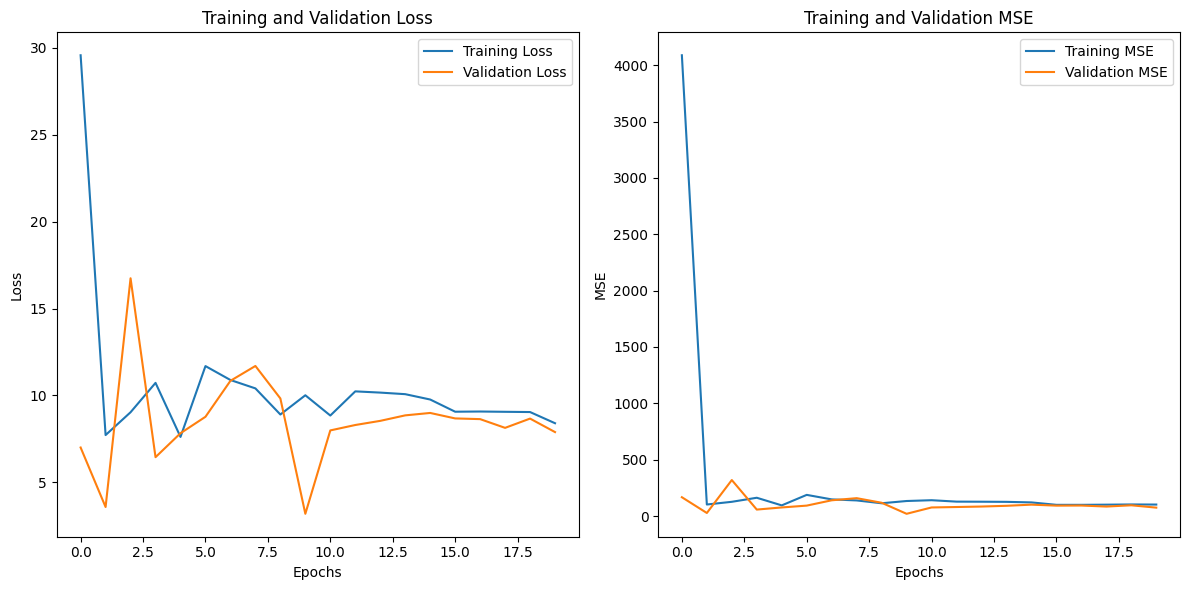

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot mean squared error
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Training and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

## VARMA

In [ ]:
dataset = pd.read_csv('/content/simulated_data_feb17.csv')
dataset = dataset.drop(columns=['timestamp'])
values = dataset.to_numpy()
encoder = LabelEncoder()
values[:,18] = encoder.fit_transform(values[:,18])
reframed = series_to_supervised(values,1,1)

values = reframed.values
# split October 1-12 for training and October 13-15 for testing
split_time = 3456
train = values[:split_time, :].astype('float32')
test = values[split_time:, :].astype('float32')
train_X, train_y = train[:, :-2], train[:, -2:-1]
test_X, test_y = test[:, :-2], test[:, -2:-1]

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                  Statespace Model Results                                 
Dep. Variable:     ['Latitude_SV', 'Longitude_SV']   No. Observations:                 3225
Model:                                  VARMA(1,1)   Log Likelihood               34608.823
                                       + intercept   AIC                         -69191.647
Date:                             Sat, 29 Mar 2025   BIC                         -69112.624
Time:                                     22:53:16   HQIC                        -69163.327
Sample:                                          0                                         
                                            - 3225                                         
Covariance Type:                               opg                                         
Ljung-Box (L1) (Q):            24.25, 3.98   Jarque-Bera (JB):           5.02, 0.90
Prob(Q):                        0.00, 0.05   Prob(JB):                   0.08, 0.64
Hete

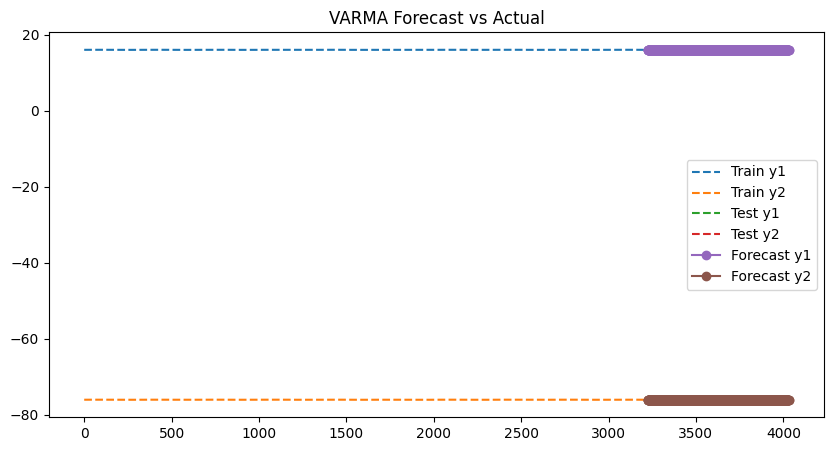

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VARMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


# Split data into training and testing sets
train_size = int(len(dataset) * 0.8)  # 80% training, 20% testing
train_data = dataset[["Latitude_SV", "Longitude_SV"]].iloc[:train_size]
test_data = dataset[["Latitude_SV", "Longitude_SV"]].iloc[train_size:]

# Fit a VARMA model on the training data
model = VARMAX(train_data, order=(1, 1))
results = model.fit(disp=False)

# Print summary
print(results.summary())

# Forecast future values for the test data
forecast_steps = len(test_data)
forecast = results.forecast(steps=forecast_steps)

# Calculate RMSE for each variable
rmse_latitude = np.sqrt(mean_squared_error(test_data['Latitude_SV'], forecast['Latitude_SV']))
rmse_longitude = np.sqrt(mean_squared_error(test_data['Longitude_SV'], forecast['Longitude_SV']))

print(f"RMSE for Latitude_SV: {rmse_latitude}")
print(f"RMSE for Longitude_SV: {rmse_longitude}")

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(dataset.index[:train_size], train_data['Latitude_SV'], label='Train y1', linestyle='dashed')
plt.plot(dataset.index[:train_size], train_data['Longitude_SV'], label='Train y2', linestyle='dashed')
plt.plot(dataset.index[train_size:], test_data['Latitude_SV'], label='Test y1', linestyle='dashed')
plt.plot(dataset.index[train_size:], test_data['Longitude_SV'], label='Test y2', linestyle='dashed')
plt.plot(dataset.index[train_size:], forecast['Latitude_SV'], label='Forecast y1', marker='o')
plt.plot(dataset.index[train_size:], forecast['Longitude_SV'], label='Forecast y2', marker='o')
plt.legend()
plt.title("VARMA Forecast vs Actual")
plt.show()

## Prophet

In [ ]:
dataset = pd.read_csv('/content/simulated_data_feb17.csv')
dataset = dataset.drop(columns=['timestamp'])
values = dataset.to_numpy()
encoder = LabelEncoder()
values[:,18] = encoder.fit_transform(values[:,18])
reframed = series_to_supervised(values,1,1)

values = reframed.values
# split October 1-12 for training and October 13-15 for testing
split_time = 3456
train = values[:split_time, :].astype('float32')
test = values[split_time:, :].astype('float32')
train_X, train_y = train[:, :-2], train[:, -2:-1]
test_X, test_y = test[:, :-2], test[:, -2:-1]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa9sq6oqd/yy3ldi3q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpa9sq6oqd/fc827qpx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5572', 'data', 'file=/tmp/tmpa9sq6oqd/yy3ldi3q.json', 'init=/tmp/tmpa9sq6oqd/fc827qpx.json', 'output', 'file=/tmp/tmpa9sq6oqd/prophet_modelt5l97fhb/prophet_model-20250329225318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:53:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:53:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


RMSE: 1.5828297377660354


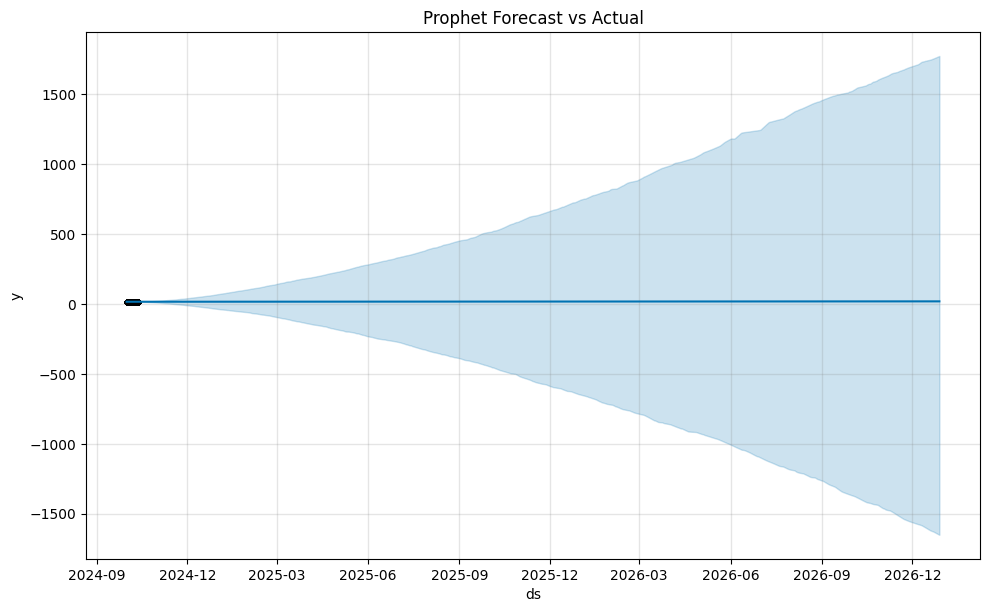

In [ ]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np

# Load dataset
dataset = pd.read_csv('/content/simulated_data_feb17.csv')

# Prepare the data for Prophet
df = pd.DataFrame({
    "ds": dataset['timestamp'],  # Timestamp column
    "y": dataset['Latitude_SV']  # Target column
})

# Split data into training and testing sets
train_size = int(len(df) * 0.8)  # 80% training, 20% testing
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

# Fit the Prophet model on the training data
m = Prophet()
m.fit(train_df)

# Create a future dataframe for the test period
future = m.make_future_dataframe(periods=len(test_df))

# Make predictions
forecast = m.predict(future)

# Extract the forecasted values for the test period
forecast_test = forecast.iloc[train_size:][['ds', 'yhat']]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_df["y"].values, forecast_test["yhat"].values))
print(f"RMSE: {rmse}")

# Plot the results
m.plot(forecast)
plt.title("Prophet Forecast vs Actual")
plt.show()

## Feature Selection

In [ ]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Load dataset
dataset = pd.read_csv('/content/simulated_data_feb17.csv')
dataset = dataset.drop(columns=['timestamp'])  # Drop timestamp column if needed

# Print dataset shape
print("Original dataset shape:", dataset.shape)

# Convert dataset to numpy array
values = dataset.to_numpy()

# Encode categorical column (if any)
encoder = LabelEncoder()
values[:, 18] = encoder.fit_transform(values[:, 18])

# Reframe data into supervised learning format (assuming series_to_supervised is defined)
reframed = series_to_supervised(values, 1, 1)
values = reframed.values

# Print reframed shape
print("Reframed dataset shape:", reframed.shape)

# Split data into training and testing sets
split_time = 3456
train = values[:split_time, :].astype('float32')
test = values[split_time:, :].astype('float32')

# Print train and test shapes
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Split into features (X) and target (y)
train_X, train_y = train[:, :-2], train[:, -2:-1]
test_X, test_y = test[:, :-2], test[:, -2:-1]

# Print train_X and test_X shapes
print("Train_X shape:", train_X.shape)
print("Test_X shape:", test_X.shape)

# Extract only the current period features (last 18 features)
# Ensure that train_X and test_X have at least 18 columns
if train_X.shape[1] < 18 or test_X.shape[1] < 18:
    raise ValueError("train_X or test_X does not have enough columns for current features.")

train_X_current = train_X[:, -18:]  # Last 18 columns are current features
test_X_current = test_X[:, -18:]    # Last 18 columns are current features

# Print current feature shapes
print("Train_X_current shape:", train_X_current.shape)
print("Test_X_current shape:", test_X_current.shape)

# Initialize the regression model
model = RandomForestRegressor(random_state=42)

# Initialize RFE to select top 10 features (adjust n_features_to_select as needed)
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit RFE to the training data (current features only)
rfe.fit(train_X_current, train_y.ravel())  # ravel() to flatten train_y to 1D array

# Transform the training and testing data to include only selected features
train_X_selected = rfe.transform(train_X_current)
test_X_selected = rfe.transform(test_X_current)

# Train the model on the selected features
model.fit(train_X_selected, train_y.ravel())

# Make predictions
y_pred = model.predict(test_X_selected)

# Evaluate the model
mse = mean_squared_error(test_y, y_pred)
print(f"Mean Squared Error with selected features: {mse:.2f}")

# Display selected features
original_feature_names = dataset.columns[:-2]  # Exclude target columns
current_feature_names = [f"{name}(t)" for name in original_feature_names]  # Current feature names

print("\nFeature Ranking:")
for feature, rank in zip(current_feature_names, rfe.ranking_):
    print(f"{feature}: {rank}")

Original dataset shape: (4032, 19)
Reframed dataset shape: (4031, 38)
Train shape: (3456, 38)
Test shape: (575, 38)
Train_X shape: (3456, 36)
Test_X shape: (575, 36)
Train_X_current shape: (3456, 18)
Test_X_current shape: (575, 18)
Mean Squared Error with selected features: 0.00

Feature Ranking:
Unnamed: 0(t): 1
Current_Velocity_U(t): 4
Current_Velocity_V(t): 2
Tidal_Velocity_U(t): 3
Tidal_Velocity_V(t): 1
Wind_Velocity_U(t): 1
Wind_Velocity_V(t): 6
Wave_Velocity(t): 1
Coriolis_Effect_U(t): 8
Coriolis_Effect_V(t): 1
Temperature(t): 1
Salinity(t): 1
Density(t): 7
Oxygen_Level(t): 9
Contamination(t): 5
Latitude_Satellite(t): 1
Longitude_Satellite(t): 1


## Adaptive Modelling

In [ ]:
# remove satellite
dataset = pd.read_csv('/content/simulated_data_feb17.csv')
dataset = dataset.drop(columns=['timestamp'])
values = dataset.to_numpy()
encoder = LabelEncoder()
values[:,16] = encoder.fit_transform(values[:,16])
reframed = series_to_supervised(values,1,1)

values = reframed.values
# split October 1-12 for training and October 13-15 for testing
split_time = 3456
train = values[:split_time, :].astype('float32')
test = values[split_time:, :].astype('float32')
train_X, train_y = train[:, :-2], train[:, -2:-1]
test_X, test_y = test[:, :-2], test[:, -2:-1]

In [ ]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming train_X, test_X, train_y, and test_y are already defined

# LSTM model
train_X = tf.expand_dims(train_X, axis=-1)
test_X = tf.expand_dims(test_X, axis=-1)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=4, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(train_X.shape[1], train_X.shape[2])),
  tf.keras.layers.LSTM(4, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

# Set the training parameters
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.8)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mean_squared_error"])

# Fit the model
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), verbose=1, shuffle=False)

# Make predictions on the test data
predictions = model.predict(test_X)

# Flatten the predictions and test_y if they have additional dimensions
predictions = [sublist[0] for sublist in predictions]
test_y = test_y.flatten()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_y, predictions))
print(f"RMSE: {rmse}")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 25.1359 - mean_squared_error: 1508.7507 - val_loss: 20.6506 - val_mean_squared_error: 471.7888
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 19.2734 - mean_squared_error: 529.2479 - val_loss: 4.5262 - val_mean_squared_error: 45.6055
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 11.2898 - mean_squared_error: 191.6064 - val_loss: 5.9773 - val_mean_squared_error: 51.1297
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 8.8232 - mean_squared_error: 148.9418 - val_loss: 10.0590 - val_mean_squared_error: 117.4996
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 13.8164 - mean_squared_error: 303.9182 - val_loss: 7.4015 - val_mean_squared_error: 66.6543
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 11.2868 - mean_squared_error: 162.8833 - val_loss: 4.3819 - val_mean_squared_error: 26.9511
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 11.1225 - mean_squared_error